In [1]:
# Core imports
import os
import pandas as pd
import numpy as np
from scipy import stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load data
clustering_df = pd.read_csv("clustering_result.csv", index_col=0)
descriptor_df = pd.read_excel("docking_result.xlsx", index_col=0)  # requires openpyxl

# Ensure indices match
if not clustering_df.index.equals(descriptor_df.index):
    raise AssertionError("Indices of clustering_df and descriptor_df do not match.")

In [2]:
# ------------------------------ #
# Benjamini–Hochberg FDR helper
# ------------------------------ #
def fdrcorrect_bh(pvals):
    """
    Benjamini–Hochberg FDR correction.
    Returns q-values in the original order of pvals.
    """
    pvals = np.asarray(pvals, dtype=float)
    n = pvals.size
    if n == 0:
        return np.array([])
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = np.empty(n, float)
    prev = 1.0
    for i in range(n - 1, -1, -1):
        rank = i + 1
        val = ranked[i] * n / rank
        prev = min(prev, val)
        q[i] = prev
    out = np.empty(n, float)
    out[order] = q
    return out


# ------------------------------ #
# Main enrichment (MWU: cluster > rest)
# ------------------------------ #
def descriptor_enrichment(
    clustering_df,
    descriptor_df,
    cluster_col="cluster",
    min_n=3
):
    """
    For each cluster, test which numeric descriptors are enriched (cluster vs. rest)
    using the one-sided Mann–Whitney U test (alternative='greater').

    Returns a DataFrame with:
      cluster, descriptor, n_in, n_out, mean_in, mean_out, delta_mean,
      effect_size (rank-biserial / Cliff's δ), test_stat (U), p_value, p_adj, signed_log10_fdr
    """
    # Join and keep cluster column + numeric descriptors
    df = clustering_df[[cluster_col]].join(descriptor_df, how="inner")

    # Numeric descriptor columns (drop constants)
    desc_cols = (
        df.drop(columns=[cluster_col])
          .select_dtypes(include=[np.number])
          .columns.tolist()
    )
    desc_cols = [c for c in desc_cols if df[c].nunique(dropna=True) > 1]

    results = []
    clusters = np.sort(df[cluster_col].dropna().unique())

    for cl in tqdm(clusters, desc="Enriching descriptors"):
        rows, pvals = [], []

        in_mask  = (df[cluster_col] == cl)
        out_mask = ~in_mask

        for col in desc_cols:
            x = df.loc[in_mask,  col].dropna().values
            y = df.loc[out_mask, col].dropna().values
            n1, n2 = x.size, y.size
            if n1 < min_n or n2 < min_n:
                continue

            # Mann–Whitney U: test whether cluster (x) > rest (y)
            u, p = stats.mannwhitneyu(x, y, alternative="greater", method="auto")

            # Rank-biserial correlation (Cliff's δ), positive => cluster higher
            effect = (2 * u) / (n1 * n2) - 1
            stat = u

            rows.append({
                "cluster": cl,
                "descriptor": col,
                "n_in": int(n1),
                "n_out": int(n2),
                "mean_in": float(np.mean(x)),
                "mean_out": float(np.mean(y)),
                "delta_mean": float(np.mean(x) - np.mean(y)),
                "effect_size": float(effect),
                "test_stat": float(stat),
                "p_value": float(p),
            })
            pvals.append(p)

        if rows:
            qvals = fdrcorrect_bh(np.array(pvals))
            for r, q in zip(rows, qvals):
                r["p_adj"] = float(q)
                r["signed_log10_fdr"] = float(np.sign(r["effect_size"]) * -np.log10(max(q, 1e-300)))
            results.extend(rows)

    res = (
        pd.DataFrame(results)
          .sort_values(["cluster", "p_adj", "effect_size"], ascending=[True, True, False])
          .reset_index(drop=True)
    )
    return res

In [3]:
import joblib

# Ensure cache directory exists
os.makedirs("joblibdata", exist_ok=True)
greater_file_path = "joblibdata/enrich_greater.joblib"

if os.path.exists(greater_file_path):
    enrich = joblib.load(greater_file_path)
else:
    enrich = descriptor_enrichment(
        clustering_df, descriptor_df,
        cluster_col="cluster",
        min_n=3
    )
    joblib.dump(enrich, greater_file_path)

enrich.head()

Enriching descriptors:   0%|          | 0/637 [00:00<?, ?it/s]

,cluster,descriptor,n_in,n_out,mean_in,mean_out,delta_mean,effect_size,test_stat,p_value,p_adj,signed_log10_fdr
0,-1,PPARA_279_THR,962,5060,0.467139,0.376912,0.090227,0.127760,2744810.5,3.041288e-11,9.945011e-09,8.002395
1,-1,FXR_336_SER,962,5060,0.566883,0.484265,0.082619,0.126136,2740856.5,1.110690e-10,1.815977e-08,7.740890
2,-1,FXR_373_TYR,962,5060,0.498147,0.412300,0.085848,0.123630,2734757.5,1.806426e-10,1.969004e-08,7.705753
3,-1,PPARA_321_LEU,962,5060,0.560820,0.478307,0.082513,0.116580,2717599.5,2.747987e-09,2.246479e-07,6.648498
4,-1,LXRB_316_THR,962,5060,0.412323,0.335181,0.077142,0.099384,2675747.5,2.909169e-07,1.902596e-05,4.720653


In [4]:
import re  # used by the label formatter

def _format_residue_label(descriptor, prefix="PPARG_"):
    """
    Convert 'PPARG_473_TYR' or 'PPARG_TYR_473' -> 'Tyr473'.
    Falls back gracefully if pattern doesn't match.
    """
    s = descriptor[len(prefix):] if descriptor.startswith(prefix) else descriptor

    # number_first: 473_TYR
    m = re.match(r"^(\d+)_([A-Za-z]+)$", s)
    if m:
        num, aa = m.groups()
        return f"{aa.title()}{num}"

    # aa_first: TYR_473
    m = re.match(r"^([A-Za-z]+)_(\d+)$", s)
    if m:
        aa, num = m.groups()
        return f"{aa.title()}{num}"

    # Fallback: remove prefix and tidy case
    parts = s.split("_")
    if len(parts) >= 2:
        aa = parts[0].title()
        num = parts[1]
        return f"{aa}{num}"
    return s.title()


def plot_pparg_enrichment_all(
    cluster_id: int,
    alpha: float = 0.05,
    min_delta: float = 0.33,
    prefix: str = "PPARG_",
    show_labels: bool = False
):
    """
    Plot ALL PPARG_* descriptors for one cluster; annotate only 'notable' ones.

    - X-axis: effect size (Cliff's δ / rank-biserial correlation)
    - Y-axis: -log10(FDR-adjusted p)
    - Notable = (p_adj < alpha) AND (|δ| >= min_delta).
    - Enrichment: one-sided MWU with alternative='greater' (cluster > rest)
    """
    if "enrich" not in globals():
        raise RuntimeError("The 'enrich' DataFrame was not found. Run the enrichment cell first.")

    # All PPARG_* rows for this cluster
    dfc = enrich[
        (enrich["cluster"] == cluster_id) &
        (enrich["descriptor"].str.startswith(prefix))
    ].copy()

    if dfc.empty:
        print(f"No descriptors starting with '{prefix}' were found for cluster {cluster_id}.")
        return

    dfc["neglog10_fdr"] = -np.log10(dfc["p_adj"].clip(lower=1e-300))

    # Notable vs other
    notable_mask = (dfc["p_adj"] < alpha) & (dfc["effect_size"].abs() >= min_delta)
    df_notable = dfc[notable_mask].copy()
    df_other   = dfc[~notable_mask].copy()

    # --- Plot ---
    plt.figure(figsize=(3.2, 3.0), dpi=300)

    # Non-notable points: light gray fill, dark gray edge
    if not df_other.empty:
        plt.scatter(
            df_other["effect_size"], df_other["neglog10_fdr"],
            s=50, alpha=0.5,
            facecolors="#bdbdbd", edgecolors="#4d4d4d", linewidths=0.8, zorder=1
        )

    # Notable points: red fill, dark red edge
    if not df_notable.empty:
        plt.scatter(
            df_notable["effect_size"], df_notable["neglog10_fdr"],
            s=60, alpha=0.85,
            facecolors="#d62728", edgecolors="#8b0000", linewidths=1.0, zorder=2
        )

    # Guideline(s)
    x_alpha = -np.log10(alpha)
    plt.axvline(min_delta, linestyle="--", color='red', zorder=0)   # only positive side (cluster > rest)
    plt.axhline(x_alpha,  linestyle="--", color='red', zorder=0)    # FDR threshold

    # Optional labels: ONLY notable points
    if show_labels and not df_notable.empty:
        for _, r in df_notable.iterrows():
            clean_label = _format_residue_label(r["descriptor"], prefix=prefix)
            plt.annotate(
                clean_label,
                (r["effect_size"], r["neglog10_fdr"]),
                textcoords="offset points", xytext=(6, 6), fontsize=8
            )

    # Labels and title
    plt.xlabel("Effect size (Cliff's δ / rank-biserial)")
    plt.ylabel("-log10(FDR-adjusted p)")
    plt.title(f"{prefix.rstrip('_')}_* enrichment — Cluster {cluster_id}")

    # X/Y limits with margin
    xmin = min(-0.34, float(dfc["effect_size"].min()) - 0.05)
    xmax = max( 0.34, float(dfc["effect_size"].max()) + 0.05)
    ymin = -0.5
    ymax = float(dfc["neglog10_fdr"].max()) + 0.5

    plt.xlim(xmin * 1.2, xmax * 1.2)
    plt.ylim(ymin, ymax)

    # Highlight region where x >= min_delta and y >= -log10(alpha)
    ax = plt.gca()
    rect_width  = ax.get_xlim()[1] - min_delta
    rect_height = ax.get_ylim()[1] - x_alpha
    if rect_width > 0 and rect_height > 0:
        ax.add_patch(plt.Rectangle((min_delta, x_alpha), rect_width, rect_height,
                                   color="#ffcc00", alpha=0.2, zorder=-1))

    plt.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)
    plt.tight_layout()
    plt.show()


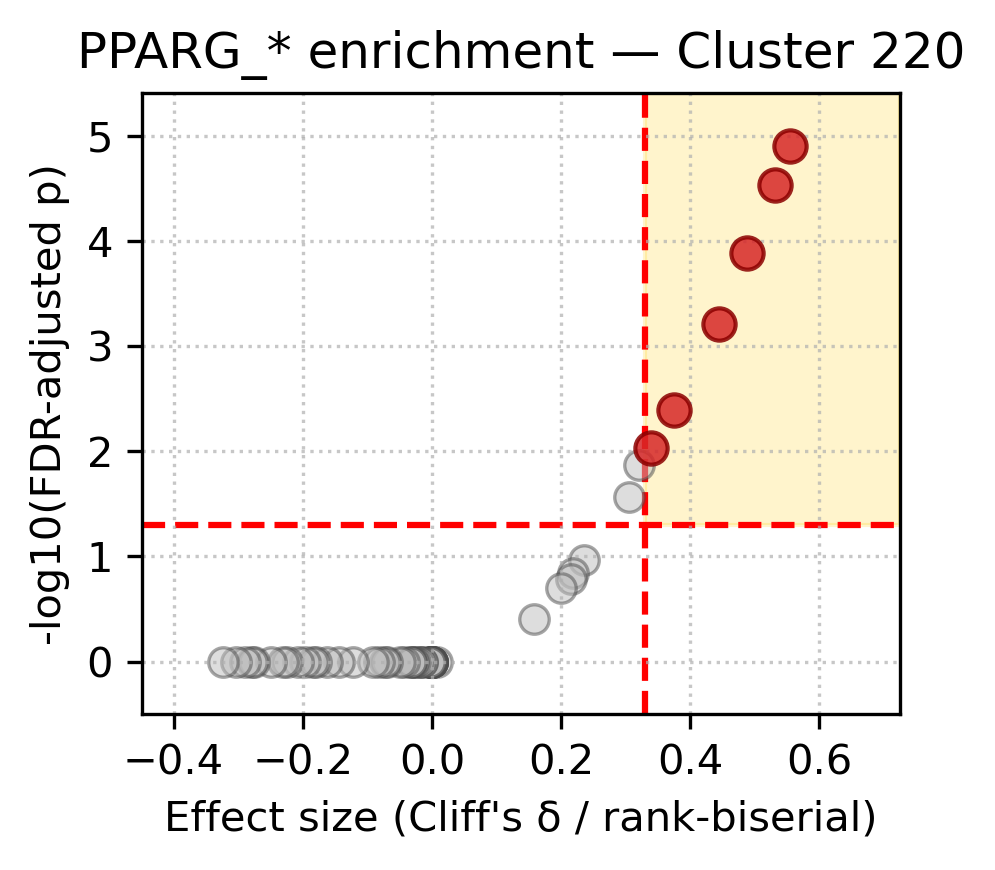

In [5]:
plot_pparg_enrichment_all(cluster_id=220, alpha=0.05, min_delta=0.33, prefix="PPARG_", show_labels=False)